# Image generation in JAX: a simple diffusion model

[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/jax-ml/jax-ai-stack/blob/main/docs/digits_diffusion_model.ipynb)

In [Debugging in JAX: a Variational autoencoder (VAE) model](digits_vae.ipynb) you explored a simplified version of a [Variational Autoencoder (VAE)](https://en.wikipedia.org/wiki/Variational_autoencoder) trained on the simple digits data. In this tutorial you will find the steps to develop, train and perform inferences with a simple diffusion model developed with JAX, Flax, NNX and Optax. It includes:
- preparing the dataset
- Developing the custom diffusion model
- Creating the loss and training functions
- Perform the model training using Colab TPU v2 as a hardware accelerator
- Visualizing and tracking your model progress.

## Setting your environment up

First you will prepare your development environment. You will need to install the required python packages:

### Installing required modules

In [ ]:
%pip install jax-ai-stack -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 780.7/780.7 kB 13.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 59.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.6/289.6 kB 18.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 270.5/270.5 kB 17.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.5/62.5 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.3/15.3 MB 99.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.1/128.1 kB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.4/42.4 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.5/49.5 kB 3.0 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.15.0 requires ml-dtypes~=0.2.0, but you have ml-dtypes 0.4.0 which is incompatible.


Then import the required modules:

In [ ]:
import jax
import optax
from flax import nnx
import jax.numpy as jnp
from functools import partial
import matplotlib.pyplot as plt
from sklearn.datasets import load_digits
from typing import Tuple, Callable, List, Optional
from sklearn.model_selection import train_test_split

### Checking if the Colab TPU devices are available at the Colab instance

If you are running this code on [Google Colab](https://colab.research.google.com/), you must select the runtime with a Google TPU v2 as hardware accelerator - The output of the cell below will be a list of 8 (eight) TPU devices:

In [ ]:
# Check available JAX devices
jax.devices()

[TpuDevice(id=0, process_index=0, coords=(0,0,0), core_on_chip=0),
 TpuDevice(id=1, process_index=0, coords=(0,0,0), core_on_chip=1),
 TpuDevice(id=2, process_index=0, coords=(1,0,0), core_on_chip=0),
 TpuDevice(id=3, process_index=0, coords=(1,0,0), core_on_chip=1),
 TpuDevice(id=4, process_index=0, coords=(0,1,0), core_on_chip=0),
 TpuDevice(id=5, process_index=0, coords=(0,1,0), core_on_chip=1),
 TpuDevice(id=6, process_index=0, coords=(1,1,0), core_on_chip=0),
 TpuDevice(id=7, process_index=0, coords=(1,1,0), core_on_chip=1)]

## Loading the digits

As before, you will use the small, self-contained [scikit-learn digits dataset](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_digits.html) for ease of experimentation and also will get only the digits '1' (one) from the dataset:

Training set size: 172
Test set size: 10


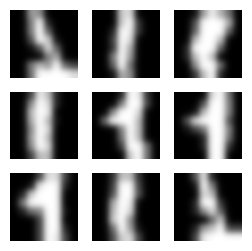

In [ ]:
# Data preprocessing
digits = load_digits()
images = digits.images[digits.target == 1] # Filter images of digit '1'
images = images / 16.0 # Normalize pixel values to [0, 1]
images = jnp.asarray(images) # Convert to JAX array
images = images.reshape(-1, 8, 8, 1) # Reshape to (num_images, height, width, channels)

# Split the dataset
images_train, images_test = train_test_split(images, test_size=0.05, random_state=42)
print(f"Training set size: {images_train.shape[0]}")
print(f"Test set size: {images_test.shape[0]}")

# Visualize sample images
fig, axes = plt.subplots(3, 3, figsize=(3, 3))
for i, ax in enumerate(axes.flat):
    if i < len(images_train):
        ax.imshow(images_train[i, ..., 0], cmap='gray', interpolation='gaussian')
        ax.axis('off')
plt.show()

## Building your diffusion model

Now you will start developing the parts of your [diffusion model](https://en.wikipedia.org/wiki/Diffusion_model). It is composed of a [UNet architecture](https://en.wikipedia.org/wiki/U-Net) backbone and the diffusion layers.

### U-Net Architecture

The U-Net architecture serves as the backbone of our diffusion model. It consists of:
- An encoder path with downsampling;
- A bridge with an [attention mechanism](https://en.wikipedia.org/wiki/Attention_(machine_learning));
- A decoder path with upsampling;
- Skip connections between encoder and decoder.

In [ ]:
class UNet(nnx.Module):
    def __init__(self,
                 in_channels: int,
                 out_channels: int,
                 features: int,
                 time_emb_dim: int = 128,
                 *,
                 rngs: nnx.Rngs):
        """
        Initialize UNet architecture with time embedding
        """
        self.features = features

        # Time embedding layers for diffusion timestep conditioning
        self.time_mlp_1 = nnx.Linear(in_features=time_emb_dim, out_features=time_emb_dim, rngs=rngs)
        self.time_mlp_2 = nnx.Linear(in_features=time_emb_dim, out_features=time_emb_dim, rngs=rngs)

        # Time projection layers for different scales
        self.time_proj1 = nnx.Linear(in_features=time_emb_dim, out_features=features, rngs=rngs)
        self.time_proj2 = nnx.Linear(in_features=time_emb_dim, out_features=features * 2, rngs=rngs)
        self.time_proj3 = nnx.Linear(in_features=time_emb_dim, out_features=features * 4, rngs=rngs)
        self.time_proj4 = nnx.Linear(in_features=time_emb_dim, out_features=features * 8, rngs=rngs)

        # Encoder path
        self.down_conv1 = self._create_residual_block(in_channels, features, rngs)
        self.down_conv2 = self._create_residual_block(features, features * 2, rngs)
        self.down_conv3 = self._create_residual_block(features * 2, features * 4, rngs)
        self.down_conv4 = self._create_residual_block(features * 4, features * 8, rngs)

        # Multi-head self-attention blocks
        self.attention1 = self._create_attention_block(features * 4, rngs)
        self.attention2 = self._create_attention_block(features * 8, rngs)

        # Bridge connecting encoder and decoder
        self.bridge_down = self._create_residual_block(features * 8, features * 16, rngs)
        self.bridge_attention = self._create_attention_block(features * 16, rngs)
        self.bridge_up = self._create_residual_block(features * 16, features * 16, rngs)

        # Decoder path with skip connections
        self.up_conv4 = self._create_residual_block(features * 24, features * 8, rngs)
        self.up_conv3 = self._create_residual_block(features * 12, features * 4, rngs)
        self.up_conv2 = self._create_residual_block(features * 6, features * 2, rngs)
        self.up_conv1 = self._create_residual_block(features * 3, features, rngs)

        # Output layers
        self.final_norm = nnx.LayerNorm(features, rngs=rngs)
        self.final_conv = nnx.Conv(in_features=features,
                                 out_features=out_channels,
                                 kernel_size=(3, 3),
                                 strides=(1, 1),
                                 padding=((1, 1), (1, 1)),
                                 rngs=rngs)

    def _create_attention_block(self, channels: int, rngs: nnx.Rngs) -> Callable:
        """Creates a self-attention block with learned query, key, value projections"""
        query_proj = nnx.Linear(in_features=channels, out_features=channels, rngs=rngs)
        key_proj = nnx.Linear(in_features=channels, out_features=channels, rngs=rngs)
        value_proj = nnx.Linear(in_features=channels, out_features=channels, rngs=rngs)

        def forward(x: jax.Array) -> jax.Array:
            B, H, W, C = x.shape
            scale = jnp.sqrt(C).astype(x.dtype)

            # Project into query, key, value spaces
            q = query_proj(x)
            k = key_proj(x)
            v = value_proj(x)

            # Reshape for attention computation
            q = q.reshape(B, H * W, C)
            k = k.reshape(B, H * W, C)
            v = v.reshape(B, H * W, C)

            # Compute scaled dot-product attention
            attention = jnp.einsum('bic,bjc->bij', q, k) / scale
            attention = jax.nn.softmax(attention, axis=-1)

            out = jnp.einsum('bij,bjc->bic', attention, v)
            out = out.reshape(B, H, W, C)

            return x + out

        return forward

    def _create_residual_block(self,
                              in_channels: int,
                              out_channels: int,
                              rngs: nnx.Rngs) -> Callable:
        """Creates a residual block with two convolutions and normalization"""
        conv1 = nnx.Conv(in_features=in_channels,
                        out_features=out_channels,
                        kernel_size=(3, 3),
                        strides=(1, 1),
                        padding=((1, 1), (1, 1)),
                        rngs=rngs)
        norm1 = nnx.LayerNorm(out_channels, rngs=rngs)
        conv2 = nnx.Conv(in_features=out_channels,
                        out_features=out_channels,
                        kernel_size=(3, 3),
                        strides=(1, 1),
                        padding=((1, 1), (1, 1)),
                        rngs=rngs)
        norm2 = nnx.LayerNorm(out_channels, rngs=rngs)

        # Projection shortcut if dimensions change
        shortcut = nnx.Conv(in_features=in_channels,
                            out_features=out_channels,
                            kernel_size=(1, 1),
                            strides=(1, 1),
                            rngs=rngs)

        def forward(x: jax.Array) -> jax.Array:
            identity = shortcut(x)

            x = conv1(x)
            x = norm1(x)
            x = nnx.gelu(x)

            x = conv2(x)
            x = norm2(x)
            x = nnx.gelu(x)

            return x + identity

        return forward

    def _pos_encoding(self, t: jax.Array, dim: int) -> jax.Array:
        """Sinusoidal positional encoding for time embedding"""
        half_dim = dim // 2
        emb = jnp.log(10000.0) / (half_dim - 1)
        emb = jnp.exp(jnp.arange(half_dim) * -emb)
        emb = t[:, None] * emb[None, :]
        emb = jnp.concatenate([jnp.sin(emb), jnp.cos(emb)], axis=1)
        return emb

    def _downsample(self, x: jax.Array) -> jax.Array:
        """Max pooling for downsampling"""
        return nnx.max_pool(x, window_shape=(2, 2), strides=(2, 2), padding='SAME')

    def _upsample(self, x: jax.Array, target_size: int) -> jax.Array:
        """Nearest neighbor upsampling"""
        return jax.image.resize(x,
                              (x.shape[0], target_size, target_size, x.shape[3]),
                              method='nearest')

    def __call__(self, x: jax.Array, t: jax.Array) -> jax.Array:
        """Forward pass through the UNet"""
        # Time embedding and projection
        t_emb = self._pos_encoding(t, 128)
        t_emb = self.time_mlp_1(t_emb)
        t_emb = nnx.gelu(t_emb)
        t_emb = self.time_mlp_2(t_emb)

        # Project time embeddings for each scale
        t_emb1 = self.time_proj1(t_emb)[:, None, None, :]
        t_emb2 = self.time_proj2(t_emb)[:, None, None, :]
        t_emb3 = self.time_proj3(t_emb)[:, None, None, :]
        t_emb4 = self.time_proj4(t_emb)[:, None, None, :]

        # Encoder path with time injection
        d1 = self.down_conv1(x)
        t_emb1 = jnp.broadcast_to(t_emb1, d1.shape)
        d1 = d1 + t_emb1

        d2 = self.down_conv2(self._downsample(d1))
        t_emb2 = jnp.broadcast_to(t_emb2, d2.shape)
        d2 = d2 + t_emb2

        d3 = self.down_conv3(self._downsample(d2))
        d3 = self.attention1(d3)
        t_emb3 = jnp.broadcast_to(t_emb3, d3.shape)
        d3 = d3 + t_emb3

        d4 = self.down_conv4(self._downsample(d3))
        d4 = self.attention2(d4)
        t_emb4 = jnp.broadcast_to(t_emb4, d4.shape)
        d4 = d4 + t_emb4

        # Bridge
        b = self._downsample(d4)
        b = self.bridge_down(b)
        b = self.bridge_attention(b)
        b = self.bridge_up(b)

        # Decoder path with skip connections
        u4 = self.up_conv4(jnp.concatenate([self._upsample(b, d4.shape[1]), d4], axis=-1))
        u3 = self.up_conv3(jnp.concatenate([self._upsample(u4, d3.shape[1]), d3], axis=-1))
        u2 = self.up_conv2(jnp.concatenate([self._upsample(u3, d2.shape[1]), d2], axis=-1))
        u1 = self.up_conv1(jnp.concatenate([self._upsample(u2, d1.shape[1]), d1], axis=-1))

        # Final layers
        x = self.final_norm(u1)
        x = nnx.gelu(x)
        return self.final_conv(x)

### Diffusion Model

Now it is time to create the second part of your diffusion model. It will rely on the UNet model and will include all the layers needed to perform the diffusion operations.

This class implements the diffusion process with:
- Forward diffusion (adding noise)
- Reverse diffusion (denoising)
- Custom noise scheduling

In [ ]:
class DiffusionModel:
    def __init__(self,
                 model: UNet,
                 num_steps: int,
                 beta_start: float,
                 beta_end: float):
        """Initialize diffusion process parameters"""
        self.model = model
        self.num_steps = num_steps

        # Noise schedule parameters
        self.beta = self._cosine_beta_schedule(num_steps, beta_start, beta_end)
        self.alpha = 1 - self.beta
        self.alpha_cumulative = jnp.cumprod(self.alpha)

        self.sqrt_alpha_cumulative = jnp.sqrt(self.alpha_cumulative)
        self.sqrt_one_minus_alpha_cumulative = jnp.sqrt(1 - self.alpha_cumulative)
        self.sqrt_recip_alpha = jnp.sqrt(1 / self.alpha)

        self.posterior_variance = self.beta * (1 - self.alpha_cumulative) / (1 - self.alpha_cumulative + 1e-7)

    def _cosine_beta_schedule(self,
                            num_steps: int,
                            beta_start: float,
                            beta_end: float) -> jax.Array:
        """Cosine schedule for noise levels"""
        steps = jnp.linspace(0, num_steps, num_steps + 1)
        x = steps / num_steps
        alphas = jnp.cos(((x + 0.008) / 1.008) * jnp.pi * 0.5) ** 2
        alphas = alphas / alphas[0]
        betas = 1 - (alphas[1:] / alphas[:-1])
        betas = jnp.clip(betas, beta_start, beta_end)
        return jnp.concatenate([betas[0:1], betas])

    def forward(self,
                x: jax.Array,
                t: jax.Array,
                key: jax.Array) -> Tuple[jax.Array, jax.Array]:
        """Forward diffusion process - adds noise according to schedule"""
        noise = jax.random.normal(key, x.shape)
        noisy_x = (
            jnp.sqrt(self.alpha_cumulative[t])[:, None, None, None] * x +
            jnp.sqrt(1 - self.alpha_cumulative[t])[:, None, None, None] * noise
        )
        return noisy_x, noise

    def reverse(self, x: jax.Array, key: jax.Array) -> jax.Array:
        """Reverse diffusion process - removes noise gradually"""
        x_t = x
        for t in reversed(range(self.num_steps)):
            t_batch = jnp.array([t] * x.shape[0])
            predicted = self.model(x_t, t_batch)

            key, subkey = jax.random.split(key)
            noise = jax.random.normal(subkey, x_t.shape) if t > 0 else 0

            x_t = (1 / jnp.sqrt(self.alpha[t])) * (
                x_t - ((1 - self.alpha[t]) / jnp.sqrt(1 - self.alpha_cumulative[t])) * predicted
            ) + jnp.sqrt(self.beta[t]) * noise

        return x_t

## Training Components

In this section, you will define the training components for our model, including:
- A Loss function (`loss_fn()`) with [SNR weighting](https://en.wikipedia.org/wiki/Signal-to-noise_ratio) and gradient penalty
- The training step (`train_step()`) with [gradient clipping](https://arxiv.org/pdf/1905.11881)

Next, you will define your model configuration and the training loop implementation.

In [ ]:
def loss_fn(model: UNet,
           images: jax.Array,
           t: jax.Array,
           noise: jax.Array,
           sqrt_alpha_cumulative: jax.Array,
           sqrt_one_minus_alpha_cumulative: jax.Array) -> jax.Array:
    """Loss function with SNR weighting and adaptive noise scaling"""

    # Compute noisy images
    noisy_images = (
        sqrt_alpha_cumulative[t][:, None, None, None] * images +
        sqrt_one_minus_alpha_cumulative[t][:, None, None, None] * noise
    )

    predicted = model(noisy_images, t)

    # SNR-weighted loss computation
    snr = (sqrt_alpha_cumulative[t] / sqrt_one_minus_alpha_cumulative[t])[:, None, None, None]
    loss_weights = snr / (1 + snr)

    squared_error = (noise - predicted) ** 2
    main_loss = jnp.mean(loss_weights * squared_error)

    # Gradient penalty with reduced coefficient
    grad = jax.grad(lambda x: model(x, t).mean())(noisy_images)
    grad_penalty = 0.02 * (jnp.square(grad).mean())

    return main_loss + grad_penalty

@nnx.jit
def train_step(model: UNet,
               optimizer: nnx.Optimizer,
               images: jax.Array,
               t: jax.Array,
               noise: jax.Array,
               sqrt_alpha_cumulative: jax.Array,
               sqrt_one_minus_alpha_cumulative: jax.Array) -> jax.Array:
    """Single training step with gradient clipping"""
    loss, grads = nnx.value_and_grad(loss_fn)(
        model, images, t, noise,
        sqrt_alpha_cumulative, sqrt_one_minus_alpha_cumulative
    )

    # Conservative gradient clipping
    clip_threshold = 0.3
    grads = jax.tree_util.tree_map(
        lambda g: jnp.clip(g, -clip_threshold, clip_threshold),
        grads
    )

    optimizer.update(grads)
    return loss

### Model Training Configuration

Now, you set up:
- Model hyperparameters;
- An optimizer with learning rate schedule.

In [ ]:
# Model and training hyperparameters
key = jax.random.PRNGKey(42)
in_channels = 1
out_channels = 1
features = 64
num_steps = 1000
num_epochs = 5000
batch_size = 64
learning_rate = 1e-4
beta_start = 1e-4
beta_end = 0.02

# Initialize model components
key, subkey = jax.random.split(key)
model = UNet(in_channels, out_channels, features, rngs=nnx.Rngs(default=subkey))

diffusion = DiffusionModel(
    model=model,
    num_steps=num_steps,
    beta_start=beta_start,
    beta_end=beta_end
)

In [ ]:
# Learning rate schedule configuration
warmup_steps = 1000
total_steps = num_epochs

schedule_fn = optax.join_schedules(
    schedules=[
        optax.linear_schedule(
            init_value=0.0,
            end_value=learning_rate,
            transition_steps=warmup_steps
        ),
        optax.cosine_decay_schedule(
            init_value=learning_rate,
            decay_steps=total_steps - warmup_steps,
            alpha=0.01
        )
    ],
    boundaries=[warmup_steps]
)

# Optimizer configuration
optimizer = nnx.Optimizer(model, optax.chain(
    optax.clip_by_global_norm(0.5),
    optax.adamw(
        learning_rate=schedule_fn,
        weight_decay=2e-5,
        b1=0.9,
        b2=0.999,
        eps=1e-8
    )
))

# Model initialization with dummy input
dummy_input = jnp.ones((1, 8, 8, 1))
dummy_t = jnp.zeros((1,), dtype=jnp.int32)
output = model(dummy_input, dummy_t)

print("Input shape:", dummy_input.shape)
print("Output shape:", output.shape)
print("\nModel initialized successfully")

Input shape: (1, 8, 8, 1)
Output shape: (1, 8, 8, 1)

Model initialized successfully


### Training Loop Implementation

Here you have the main training loop for the diffusion model with:
- Progressive timestep sampling strategy
- [Exponential Moving Average (EMA)](https://en.wikipedia.org/wiki/Moving_average#Exponential_moving_average) loss tracking
- Adaptive noise generation

In [ ]:
# Initialize training metrics
losses: List[float] = []                # Store EMA loss history
moving_avg_loss: Optional[float] = None  # EMA of the loss value
beta: float = 0.99                      # EMA decay factor for loss smoothing

for epoch in range(num_epochs + 1):
    # Split PRNG key for independent random operations
    key, subkey1 = jax.random.split(key)
    key, subkey2 = jax.random.split(key)

    # Progressive timestep sampling - weights early steps more heavily as training progresses
    # This helps model focus on fine details in later epochs while maintaining stability
    progress = epoch / num_epochs
    t_weights = jnp.linspace(1.0, 0.1 * (1.0 - progress), num_steps)
    t = jax.random.choice(
        subkey1,
        num_steps,
        shape=(images_train.shape[0],),
        p=t_weights/t_weights.sum()
    )

    # Generate Gaussian noise for current batch
    noise = jax.random.normal(subkey2, images_train.shape)

    # Execute training step with noise prediction and parameter updates
    loss = train_step(
        model, optimizer, images_train, t, noise,
        diffusion.sqrt_alpha_cumulative, diffusion.sqrt_one_minus_alpha_cumulative
    )

    # Update exponential moving average of loss for smoother tracking
    if moving_avg_loss is None:
        moving_avg_loss = loss
    else:
        moving_avg_loss = beta * moving_avg_loss + (1 - beta) * loss

    losses.append(moving_avg_loss)

    # Log training progress at regular intervals
    if epoch % 100 == 0:
        print(f"Epoch {epoch}, Loss: {moving_avg_loss:.4f}")

print("\nTraining completed.")

Epoch 0, Loss: 1.2441
Epoch 100, Loss: 1.1178
Epoch 200, Loss: 0.8737
Epoch 300, Loss: 0.7176
Epoch 400, Loss: 0.6327
Epoch 500, Loss: 0.5682
Epoch 600, Loss: 0.5024
Epoch 700, Loss: 0.4417
Epoch 800, Loss: 0.3805
Epoch 900, Loss: 0.3254
Epoch 1000, Loss: 0.2803
Epoch 1100, Loss: 0.2534
Epoch 1200, Loss: 0.2339
Epoch 1300, Loss: 0.2221
Epoch 1400, Loss: 0.2141
Epoch 1500, Loss: 0.2085
Epoch 1600, Loss: 0.2046
Epoch 1700, Loss: 0.1991
Epoch 1800, Loss: 0.1951
Epoch 1900, Loss: 0.1923
Epoch 2000, Loss: 0.1919
Epoch 2100, Loss: 0.1913
Epoch 2200, Loss: 0.1888
Epoch 2300, Loss: 0.1858
Epoch 2400, Loss: 0.1861
Epoch 2500, Loss: 0.1867
Epoch 2600, Loss: 0.1855
Epoch 2700, Loss: 0.1832
Epoch 2800, Loss: 0.1834
Epoch 2900, Loss: 0.1839
Epoch 3000, Loss: 0.1844
Epoch 3100, Loss: 0.1838
Epoch 3200, Loss: 0.1816
Epoch 3300, Loss: 0.1824
Epoch 3400, Loss: 0.1815
Epoch 3500, Loss: 0.1823
Epoch 3600, Loss: 0.1834
Epoch 3700, Loss: 0.1823
Epoch 3800, Loss: 0.1811
Epoch 3900, Loss: 0.1806
Epoch 4000, 

### Training loss visualization

It uses a logarithmic scale to better display the exponential decay of the loss values over time. This representation helps identify both early rapid improvements and later fine-tuning phases of the training process.

You can see that your model performs well, due to the reducing training loss over the training time.

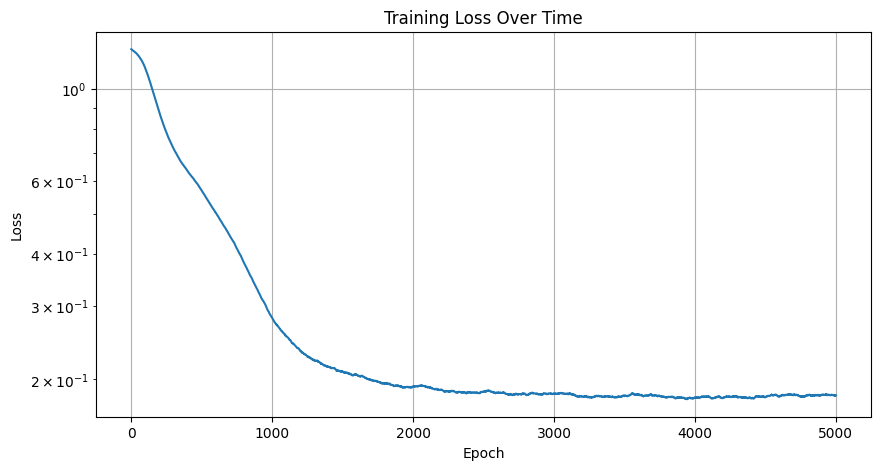

In [ ]:
# Plot the training loss history with logarithmic scaling
plt.figure(figsize=(10, 5))            # Create figure with wide aspect ratio for clarity
plt.plot(losses)                       # losses: List[float] - historical EMA loss values
plt.title('Training Loss Over Time')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.yscale('log')                      # Use log scale to better visualize exponential decay
plt.grid(True)                         # Add grid for easier value reading
plt.show()

## Visualization Functions

In this section, you will include utilities for:
- Sample generation
- Forward/reverse process visualization
- Training progress tracking

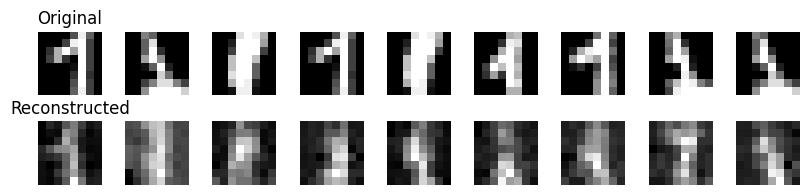

In [ ]:
@partial(nnx.jit, static_argnums=(3,))
def reverse_diffusion_batch(model: UNet,
                          x: jax.Array,
                          key: jax.Array,
                          num_steps: int) -> jax.Array:
    """Efficient batched reverse diffusion using scan"""
    beta = jnp.linspace(1e-4, 0.02, num_steps)
    alpha = 1 - beta
    alpha_cumulative = jnp.cumprod(alpha)

    def scan_step(carry: Tuple[jax.Array, jax.Array],
                 step: int) -> Tuple[Tuple[jax.Array, jax.Array], jax.Array]:
        x, key = carry
        t_batch = jnp.full((x.shape[0],), step)
        predicted = model(x, t_batch)

        key, subkey = jax.random.split(key)
        noise = jnp.where(step > 0, jax.random.normal(subkey, x.shape), 0)

        x_new = 1 / jnp.sqrt(alpha[step]) * (
            x - (1 - alpha[step]) / jnp.sqrt(1 - alpha_cumulative[step]) * predicted
        ) + jnp.sqrt(beta[step]) * noise

        return (x_new, key), x_new

    steps = jnp.arange(num_steps - 1, -1, -1)
    (final_x, _), _ = jax.lax.scan(scan_step, (x, key), steps)
    return final_x

def plot_samples(model: UNet,
                diffusion: DiffusionModel,
                images: jax.Array,
                key: jax.Array,
                num_samples: int = 9) -> None:
    """Visualize original vs reconstructed images"""
    indices = jax.random.randint(key, (num_samples,), 0, len(images))
    samples = images[indices]

    key, subkey = jax.random.split(key)
    noisy = diffusion.forward(samples, jnp.full((num_samples,), diffusion.num_steps-1), subkey)[0]

    key, subkey = jax.random.split(key)
    reconstructed = reverse_diffusion_batch(model, noisy, subkey, diffusion.num_steps)

    fig, axes = plt.subplots(2, num_samples, figsize=(8, 2))

    for i in range(num_samples):
        axes[0, i].imshow(samples[i, ..., 0], cmap='gray')
        axes[0, i].axis('off')
        axes[1, i].imshow(reconstructed[i, ..., 0], cmap='gray')
        axes[1, i].axis('off')

    axes[0, 0].set_title('Original')
    axes[1, 0].set_title('Reconstructed')
    plt.tight_layout()
    plt.show()

# Generate visualization
key, subkey = jax.random.split(key)
plot_samples(model, diffusion, images_test, subkey)


Full Forward and Reverse Process:


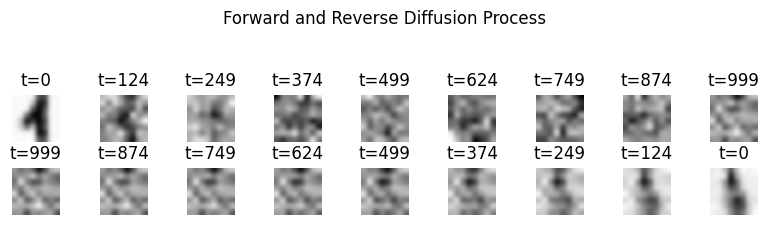

In [ ]:
@partial(nnx.jit, static_argnums=(3,))
def compute_forward_sequence(model: UNet,
                           image: jax.Array,
                           key: jax.Array,
                           num_vis_steps: int) -> jax.Array:
    """Compute forward diffusion sequence efficiently."""
    # Prepare image sequence and noise parameters
    image_repeated = jnp.repeat(image[None], num_vis_steps, axis=0)
    timesteps = jnp.linspace(0, 999, num_vis_steps).astype(jnp.int32)  # Assuming 1000 steps
    beta = jnp.linspace(1e-4, 0.02, 1000)
    alpha = 1 - beta
    alpha_cumulative = jnp.cumprod(alpha)

    # Generate and apply noise progressively
    noise = jax.random.normal(key, image_repeated.shape)
    noisy_images = (
        jnp.sqrt(alpha_cumulative[timesteps])[:, None, None, None] * image_repeated +
        jnp.sqrt(1 - alpha_cumulative[timesteps])[:, None, None, None] * noise
    )
    return noisy_images

@partial(nnx.jit, static_argnums=(3,))
def compute_reverse_sequence(model: UNet,
                           noisy_image: jax.Array,
                           key: jax.Array,
                           num_vis_steps: int) -> jax.Array:
    """Compute reverse diffusion sequence efficiently."""
    # Denoise completely and create interpolation sequence
    final_image = reverse_diffusion_batch(model, noisy_image[None], key, 1000)[0]
    alphas = jnp.linspace(0, 1, num_vis_steps)
    reverse_sequence = (
        (1 - alphas)[:, None, None, None] * noisy_image +
        alphas[:, None, None, None] * final_image
    )
    return reverse_sequence

def plot_forward_and_reverse(model: UNet,
                          diffusion: DiffusionModel,
                          image: jax.Array,
                          key: jax.Array,
                          num_steps: int = 9) -> None:
    """Plot both forward and reverse diffusion processes with optimized computation."""
    # Compute the forward/reverse transformations
    key1, key2 = jax.random.split(key)
    forward_sequence = compute_forward_sequence(model, image, key1, num_steps)
    reverse_sequence = compute_reverse_sequence(model, forward_sequence[-1], key2, num_steps)

    # Setup visualization grid
    fig, (ax1, ax2) = plt.subplots(2, num_steps, figsize=(8, 2))
    fig.suptitle('Forward and Reverse Diffusion Process', y=1.1)

    timesteps = jnp.linspace(0, diffusion.num_steps-1, num_steps).astype(jnp.int32)

    # Visualize forward diffusion
    for i in range(num_steps):
        ax1[i].imshow(forward_sequence[i, ..., 0], cmap='binary', interpolation='gaussian')
        ax1[i].axis('off')
        ax1[i].set_title(f't={timesteps[i]}')
    ax1[0].set_ylabel('Forward', rotation=90, labelpad=10)

    # Visualize reverse diffusion
    for i in range(num_steps):
        ax2[i].imshow(reverse_sequence[i, ..., 0], cmap='binary', interpolation='gaussian')
        ax2[i].axis('off')
        ax2[i].set_title(f't={timesteps[num_steps-1-i]}')
    ax2[0].set_ylabel('Reverse', rotation=90, labelpad=10)

    plt.tight_layout()
    plt.show()

# Generate visualization
key, subkey = jax.random.split(key)
print("\nFull Forward and Reverse Process:")
plot_forward_and_reverse(model, diffusion, images_test[0], subkey)

## Summary
This tutorial demonstrated the implementation of a diffusion model using JAX and Flax libraries. You explored the U-Net architecture with attention mechanisms, efficient training strategies using JIT compilation, and comprehensive visualization techniques for the diffusion process. The implementation showcases JAX's powerful features for high-performance machine learning, including automatic differentiation, vectorization, and just-in-time compilation.

Check the [JAX documentation](https://jax.readthedocs.io/en/latest/) for more tutorials and experiments with the JAX stack.